In [1]:
import numpy as np
import matplotlib.pyplot as plt

data_train = np.load('data1/noisy_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


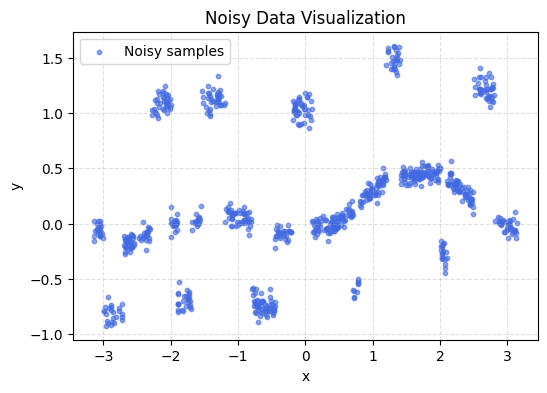

In [2]:
x_train_in = data_train["x"]
y_train_in = data_train["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=10, alpha=0.6, color="royalblue", label="Noisy samples")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


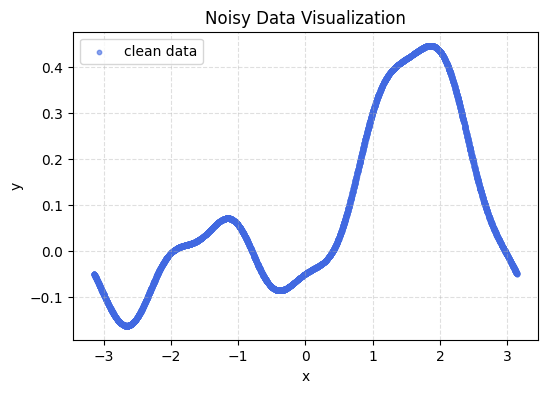

In [3]:
data_test = np.load('data1/clean_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

x_test = data_test["x"]
y_test = data_test["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_test, y_test, s=10, alpha=0.6, color="royalblue", label="clean data")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [4]:
import sys, torch, os, site
print("Python exe:", sys.executable)
print("torch file:", getattr(torch, "__file__", None))
print("has torch.version? ->", hasattr(torch, "version"))
print("User-site:", site.getusersitepackages())

Python exe: c:\Program Files\Python311\python.exe
torch file: C:\Users\mnhat\AppData\Roaming\Python\Python311\site-packages\torch\__init__.py
has torch.version? -> True
User-site: C:\Users\mnhat\AppData\Roaming\Python\Python311\site-packages


In [5]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
print("cuda in wheel:", torch.version.cuda)
from util import (
    get_torch_size_string,
    print_model_parameters,
    th2np,
)
from local_mdn import (
    MixtureDensityNetwork,
    gmm_forward,
    eval_mdn_1d,
)

2.5.1+cu121
cuda in wheel: 12.1


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.version.cuda

'12.1'

In [7]:
# when you build the model (keep k=5 if you like)
mdn = MixtureDensityNetwork(
    name='mdn',
    x_dim=1, y_dim=1, k=5,
    h_dim_list=[64,64],
    actv=nn.SiLU(),
    sig_max=2.0,      # <= tighten
    mu_min=-3.0,      # <= widen (in normalized units)
    mu_max=+3.0,
    p_drop=0.0, use_bn=False,
).to(device)
mdn.init_param()
optm = torch.optim.Adam(mdn.parameters(), lr=3e-4, eps=1e-4, weight_decay=1e-4)
schd = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=0.9999)

In [8]:
n_train = 800
x_train = torch.from_numpy(x_train_in).to(device)
y_train = torch.from_numpy(y_train_in).to(device)

In [9]:
max_iter,batch_size,print_every,plot_every = 2e4,256,1000,5000
print ("max_iter:[%d] batch_size:[%d] print_every:[%d] plot_every:[%d]"%
      (max_iter,batch_size,print_every,plot_every))

max_iter:[20000] batch_size:[256] print_every:[1000] plot_every:[5000]


In [10]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()

Start training


MixtureDensityNetwork(
  (actv): SiLU()
  (net): Sequential(
    (linear_00): Linear(in_features=1, out_features=64, bias=True)
    (silu_01): SiLU()
    (dropout1d_02): Dropout1d(p=0.0, inplace=False)
    (linear_03): Linear(in_features=64, out_features=64, bias=True)
    (silu_04): SiLU()
    (dropout1d_05): Dropout1d(p=0.0, inplace=False)
    (mixturesofgaussianlayer_06): MixturesOfGaussianLayer(
      (fc_pi): Linear(in_features=64, out_features=5, bias=True)
      (fc_mu): Linear(in_features=64, out_features=5, bias=True)
      (fc_sigma): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

[   0/20000] loss:[5.257]


C:\Users\mnhat\AppData\Local\Temp\ipykernel_35080\1424733342.py:38: UserWarning: Using a target size (torch.Size([256, 1, 1])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.huber_loss(y_batch, y_soft, delta=0.05)  # or F.mse_loss


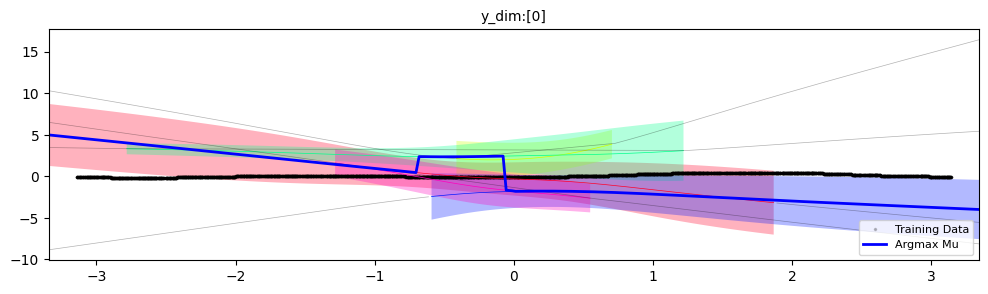

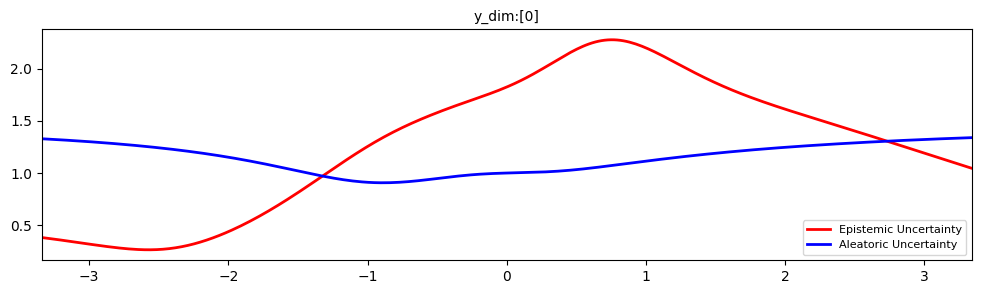

[1000/20000] loss:[0.566]
[2000/20000] loss:[0.424]
[3000/20000] loss:[0.268]
[4000/20000] loss:[0.321]
[5000/20000] loss:[0.265]


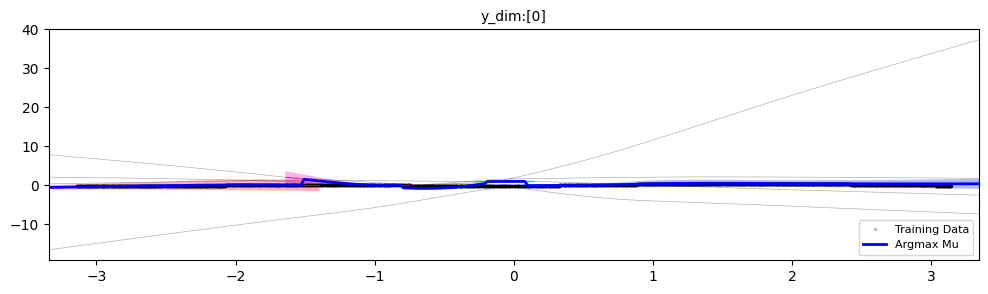

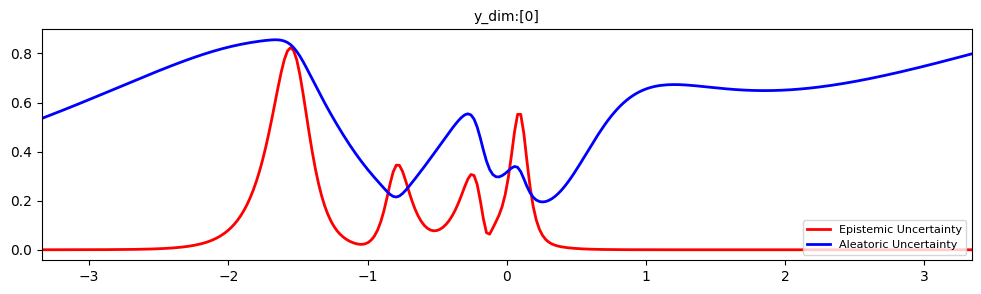

[6000/20000] loss:[0.279]
[7000/20000] loss:[0.201]
[8000/20000] loss:[0.301]
[9000/20000] loss:[0.290]
[10000/20000] loss:[0.194]


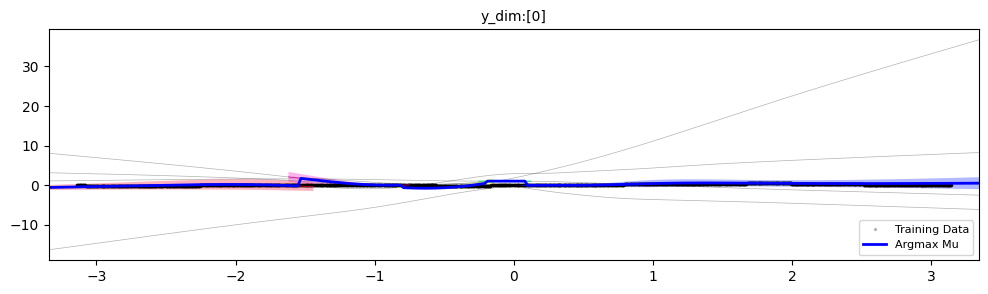

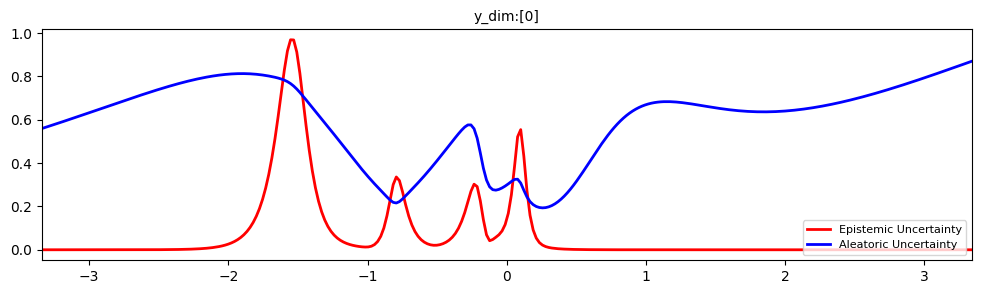

[11000/20000] loss:[0.226]
[12000/20000] loss:[0.276]
[13000/20000] loss:[0.201]
[14000/20000] loss:[0.274]
[15000/20000] loss:[0.200]


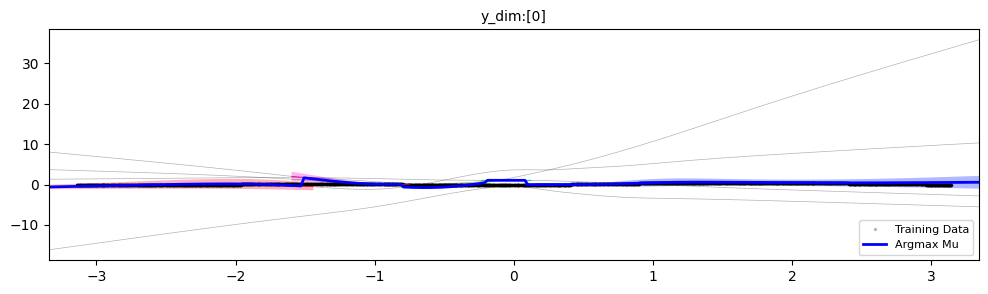

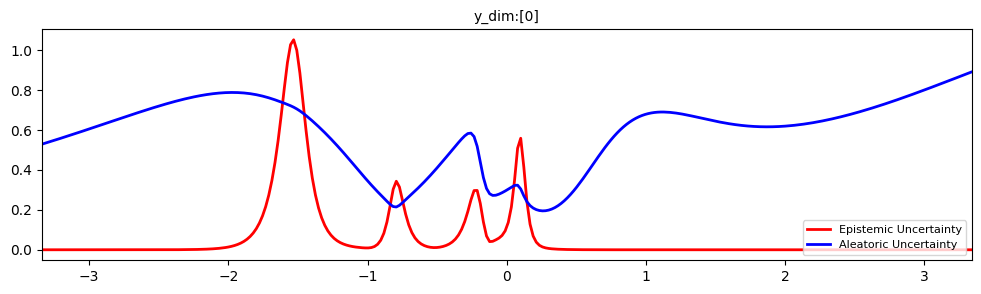

[16000/20000] loss:[0.162]
[17000/20000] loss:[0.172]
[18000/20000] loss:[0.199]
[19000/20000] loss:[0.210]
[19999/20000] loss:[0.226]


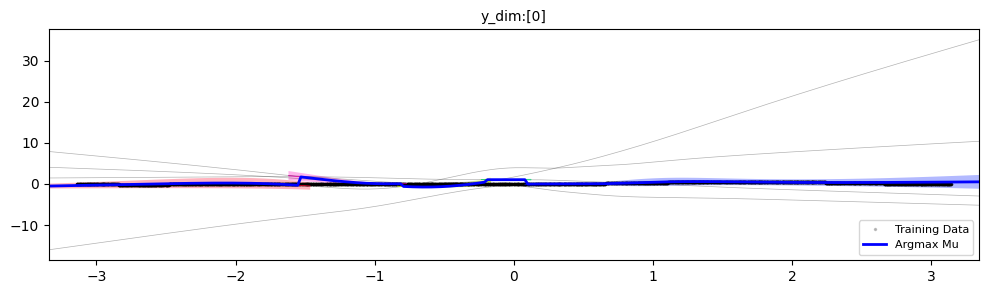

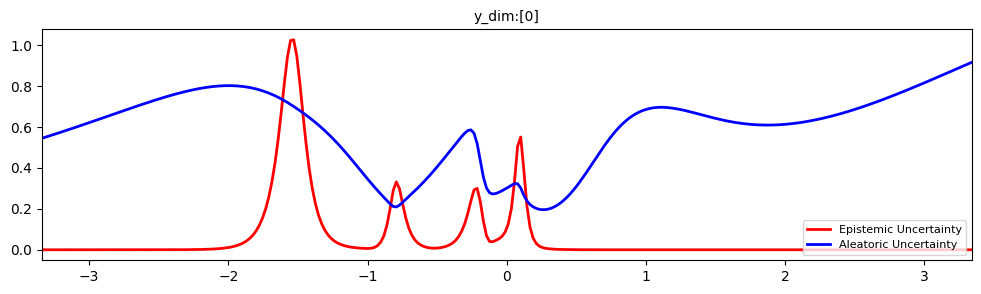

Done.


In [11]:
# --- set once before the loop ---
lam_mse = 0.20   # auxiliary regression to smooth the predicted curve
lam_ent = 1e-4   # encourage softer mixing (↑ entropy of pi)
lam_sig = 1e-5   # discourage extreme sigmas
lam_tv  = 0.0    # tiny x-smoothness (set 1e-3 to enable)
tau_mse = 0.6    # soft-argmax temperature

if isinstance(x_train, torch.Tensor): x_train = x_train.detach().cpu().numpy()
if isinstance(y_train, torch.Tensor): y_train = y_train.detach().cpu().numpy()
n_train = x_train.shape[0]

for it in range(int(max_iter)):

    batch_idx = np.random.permutation(n_train)[:batch_size]
    x_batch = torch.from_numpy(x_train[batch_idx]).float().to(device)
    y_batch = torch.from_numpy(y_train[batch_idx]).float().to(device)

    mdn.train()
    optm.zero_grad(set_to_none=True)

    # prefer mixture_params; fallback if forward() returns (pi,mu,sigma)
    try:
        pi_batch, mu_batch, sigma_batch = mdn.mixture_params(x_batch)
    except AttributeError:
        pi_batch, mu_batch, sigma_batch = mdn.forward(x_batch)

    # defensive clamps (safe even if done inside model)
    pi_batch    = torch.softmax(torch.log(pi_batch + 1e-12), dim=1).clamp_min(1e-6)
    sigma_batch = sigma_batch.clamp(1e-2, 1.0)

    # MDN NLL
    gmm_out = gmm_forward(pi_batch, mu_batch, sigma_batch, y_batch)
    nll = gmm_out['nlls'].mean()

    # soft-argmax "mode" (smooth surrogate of hard argmax) + robust loss
    w = torch.softmax(torch.log(pi_batch + 1e-12) / tau_mse, dim=1)
    y_soft = (w * mu_batch).sum(dim=1, keepdim=True)
    mse = F.huber_loss(y_batch, y_soft, delta=0.05)  # or F.mse_loss

    # tiny regularizers tailored for MDNs
    neg_entropy = (pi_batch * (pi_batch + 1e-12).log()).sum(dim=1).mean()  # = -H(π)
    sig_reg     = (torch.log(sigma_batch)**2).mean()

    # (optional) very light smoothness along x
    if lam_tv > 0:
        order = torch.argsort(x_batch[:, 0])
        i, j  = order[:-1], order[1:]
        tv    = ((y_soft[j] - y_soft[i])**2).mean()
    else:
        tv = torch.tensor(0.0, device=device)

    # ---- TOTAL LOSS (L1 removed; see note below) ----
    loss = nll + lam_mse*mse + lam_ent*neg_entropy + lam_sig*sig_reg + lam_tv*tv

    loss.backward()
    torch.nn.utils.clip_grad_norm_(mdn.parameters(), 5.0)
    optm.step()
    schd.step()

    # Print
    if ((it%print_every)==0) or (it==(max_iter-1)):
        print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))

    # Plot
    if ((it%plot_every)==0) or (it==(max_iter-1)):
        eval_mdn_1d(mdn,x_test,y_test,figsize=(12,3),device=device)
print("Done.")
    
    # ... your print/plot stay unchanged ...
